In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pydicom
import pandas as pd
from segment_anything import sam_model_registry, SamPredictor
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda")if torch.cuda.is_available() else "cpu")
sam = sam.to(device)
predictor = SamPredictor(sam)
print(f"Using device: {device}")

Using device: mps


In [3]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_mask2(mask, ax, random_color=False):
    # Determine color for the outline
    if random_color:
        color = np.random.random(3)
    else:
        color = np.array([30/255, 144/255, 255/255])
    
    h, w = mask.shape[-2:]
    
    # Create an outline by using contours
    contours = np.zeros((h, w), dtype=np.uint8)
    contours[mask > 0] = 1  # Create a binary mask where the original mask is present
    contours = np.pad(contours, pad_width=1, mode='constant', constant_values=0)
    
    # Find the contours
    from skimage.measure import find_contours
    contours_found = find_contours(contours, 0.5)

    # Plot contours
    for contour in contours_found:
        ax.plot(contour[:, 1] - 1, contour[:, 0] - 1, color=color, linewidth=2)  # Adjust for padding


In [4]:
csv_file_path = 'cleaned_train_data/cleaned_train_data.csv'
df = pd.read_csv(csv_file_path)
print(df.head())

                              patientId     x1     y1     x2     y2
0  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  477.0  531.0
1  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  818.0  605.0
2  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  483.0  681.0
3  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  857.0  712.0
4  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0  382.0  457.0


In [5]:
# Create a dictionary with patientId as keys and list of bounding box coordinates as values
bounding_boxes_dict = df.groupby('patientId')[['x1', 'y1', 'x2', 'y2']].apply(lambda x: x.values.tolist()).to_dict()
print(bounding_boxes_dict)

{'000db696-cf54-4385-b10b-6b16fbb3f985': [[316.0, 318.0, 486.0, 796.0], [660.0, 375.0, 806.0, 777.0]], '000fe35a-2649-43d4-b027-e67796d412e0': [[570.0, 282.0, 839.0, 691.0], [83.0, 227.0, 379.0, 665.0]], '001031d9-f904-4a23-b3e5-2c088acd19c6': [[66.0, 160.0, 439.0, 768.0], [552.0, 164.0, 928.0, 840.0]], '001916b8-3d30-4935-a5d1-8eaddb1646cd': [[198.0, 375.0, 312.0, 581.0]], '0022073f-cec8-42ec-ab5f-bc2314649235': [[575.0, 232.0, 821.0, 760.0], [161.0, 230.0, 384.0, 716.0]], '002cb550-2e31-42f1-a29d-fbc279977e71': [[176.0, 342.0, 346.0, 581.0], [515.0, 333.0, 682.0, 584.0]], '00436515-870c-4b36-a041-de91049b9ab4': [[264.0, 152.0, 477.0, 531.0], [562.0, 152.0, 818.0, 605.0]], '00704310-78a8-4b38-8475-49f4573b2dbb': [[323.0, 577.0, 483.0, 681.0], [695.0, 575.0, 857.0, 712.0]], '0087bd3a-55a7-4045-b111-b018fa52d361': [[257.0, 398.0, 403.0, 739.0], [647.0, 367.0, 817.0, 714.0]], '00a05408-8291-4231-886e-13763e103161': [[156.0, 187.0, 329.0, 558.0], [491.0, 194.0, 647.0, 416.0]], '00aecb01-a

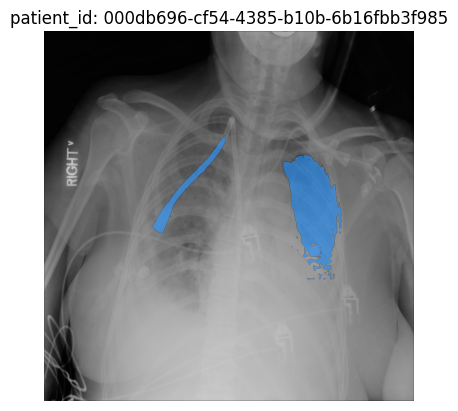

In [5]:
# Iterate through the first 2 keys of the bounding_boxes_dict
for patient_id, boxes in list(bounding_boxes_dict.items())[:1]:
    # Read the DICOM file for the current patient_id
    dcm_file_path = f'cleaned_train_data/cleaned_stage_2_train_images/{patient_id}.dcm'
    dicom = pydicom.dcmread(dcm_file_path)
    
    # Convert to 3-channel RGB image if needed by SAM
    image = dicom.pixel_array
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    plt.imshow(image_rgb)
    plt.title(f"patient_id: {patient_id}")
    
    # Encode the image into SAM
    predictor.set_image(image_rgb)

    # Initialize an empty list to hold all the masks
    all_masks = []

    # Loop over each bounding box and predict masks one at a time
    for box in boxes:
        input_box = np.array(box)
        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # Use individual bounding box
            multimask_output=False
        )
        all_masks.append(masks)  # Store masks for each box

    # Display the results
    plt.imshow(image_rgb)
    for mask, box in zip(all_masks, boxes):
        show_mask(mask[0], plt.gca())  # Show mask for each box
        # show_box(box, plt.gca())
    plt.axis('off')
    plt.show()

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor2 = SAM2ImagePredictor(sam2_model)
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

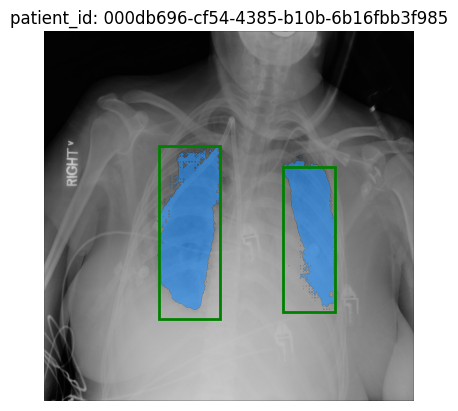

In [8]:
# Iterate through the first 2 keys of the bounding_boxes_dict
for patient_id, boxes in list(bounding_boxes_dict.items())[:1]:
    # Read the DICOM file for the current patient_id
    dcm_file_path = f'cleaned_train_data/cleaned_stage_2_train_images/{patient_id}.dcm'
    dicom = pydicom.dcmread(dcm_file_path)
    
    # Convert to 3-channel RGB image if needed by SAM
    image = dicom.pixel_array
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    plt.imshow(image_rgb)
    plt.title(f"patient_id: {patient_id}")
    
    # Convert image_rgb to a numpy array
    image_rgb = np.array(image_rgb)
    
    # Encode the image into SAM
    predictor2.set_image(image_rgb)

    # Initialize an empty list to hold all the masks
    all_masks = []

    # Loop over each bounding box and predict masks one at a time
    for box in boxes:
        input_box = np.array(box)
        masks, scores, _ = predictor2.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # Use individual bounding box
            multimask_output=False
        )
        all_masks.append(masks)  # Store masks for each box

    # Display the results
    plt.imshow(image_rgb)
    for mask, box in zip(all_masks, boxes):
        show_mask(mask[0], plt.gca())  # Show mask for each box
        show_box(box, plt.gca())
    plt.axis('off')
    plt.show()

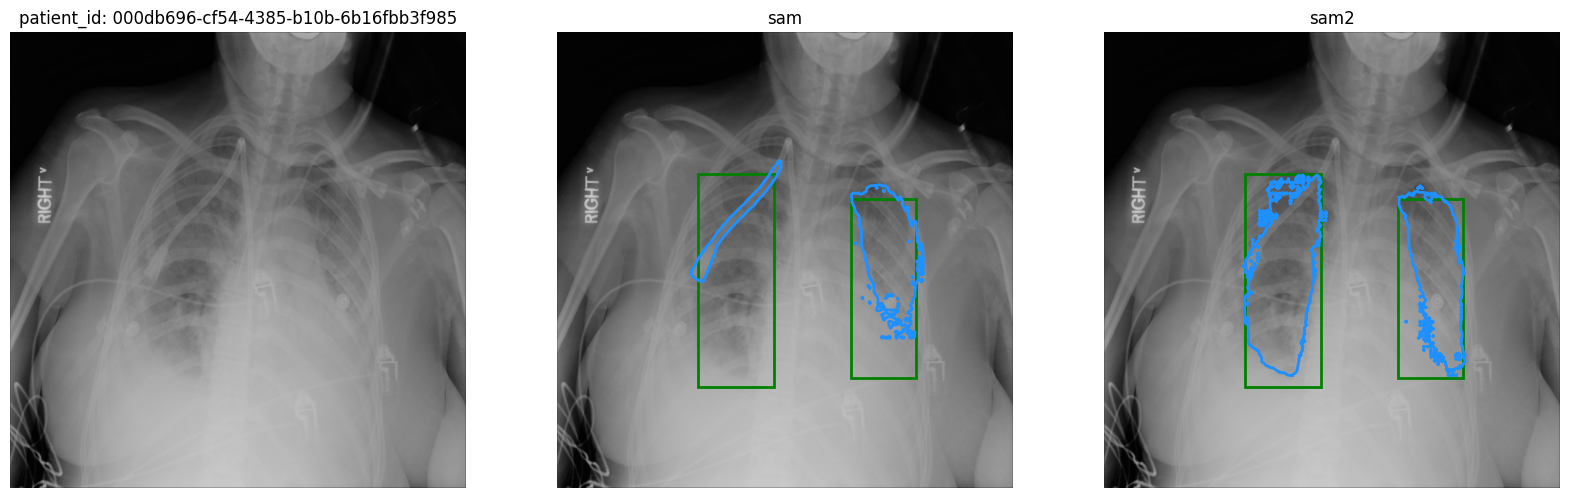

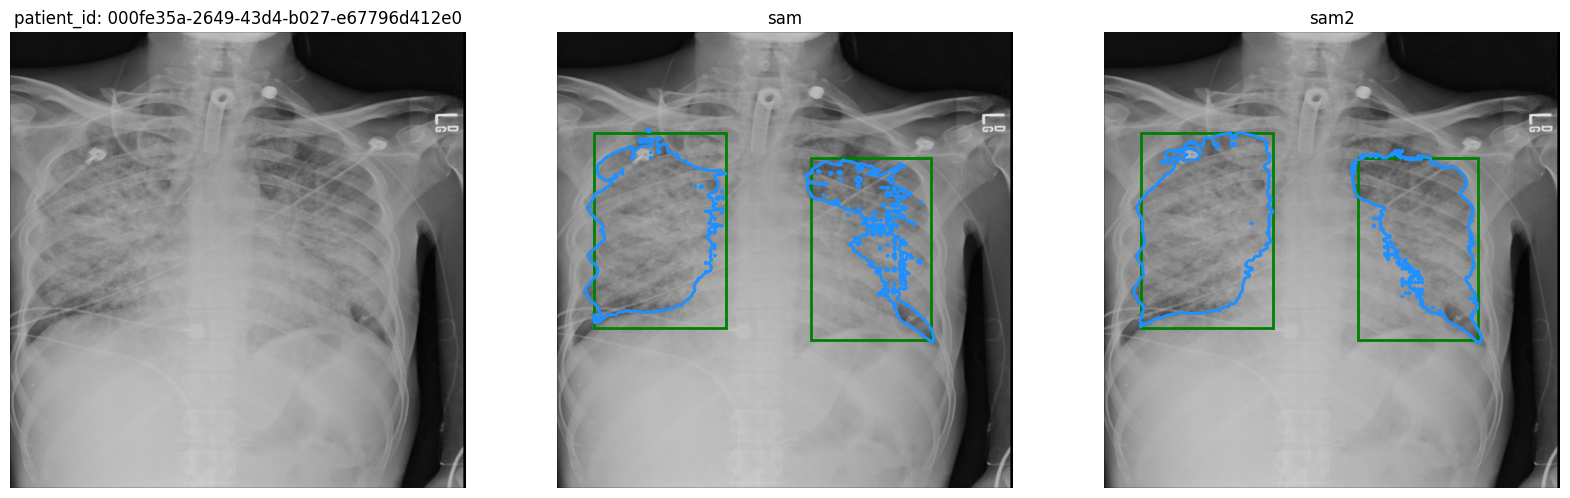

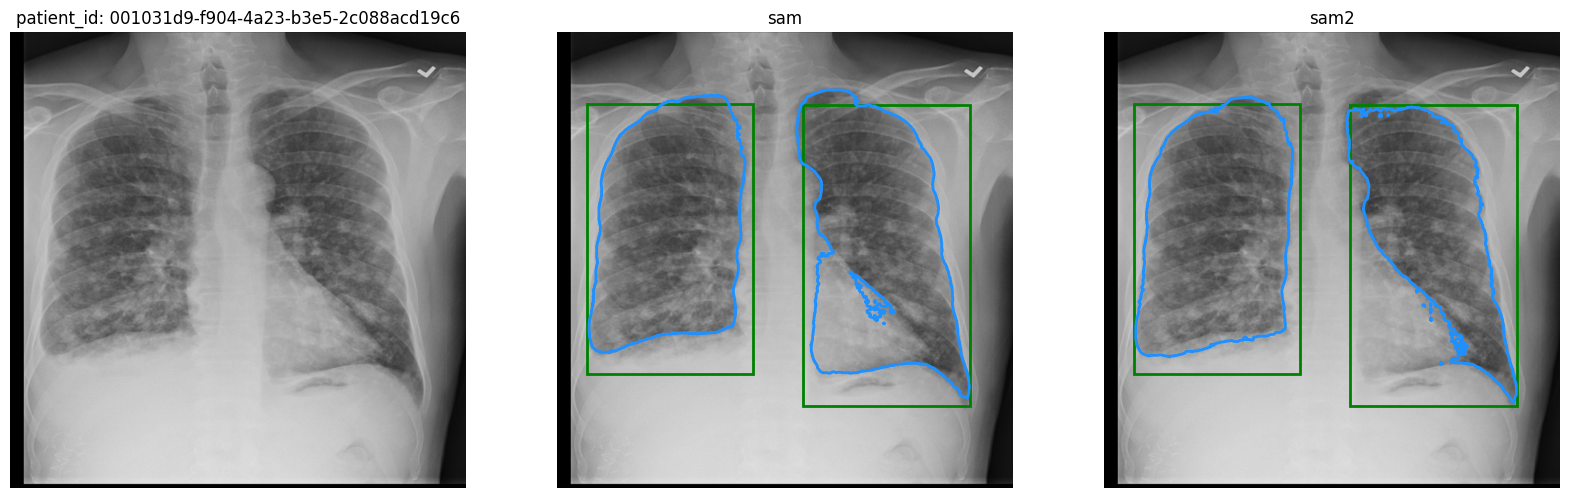

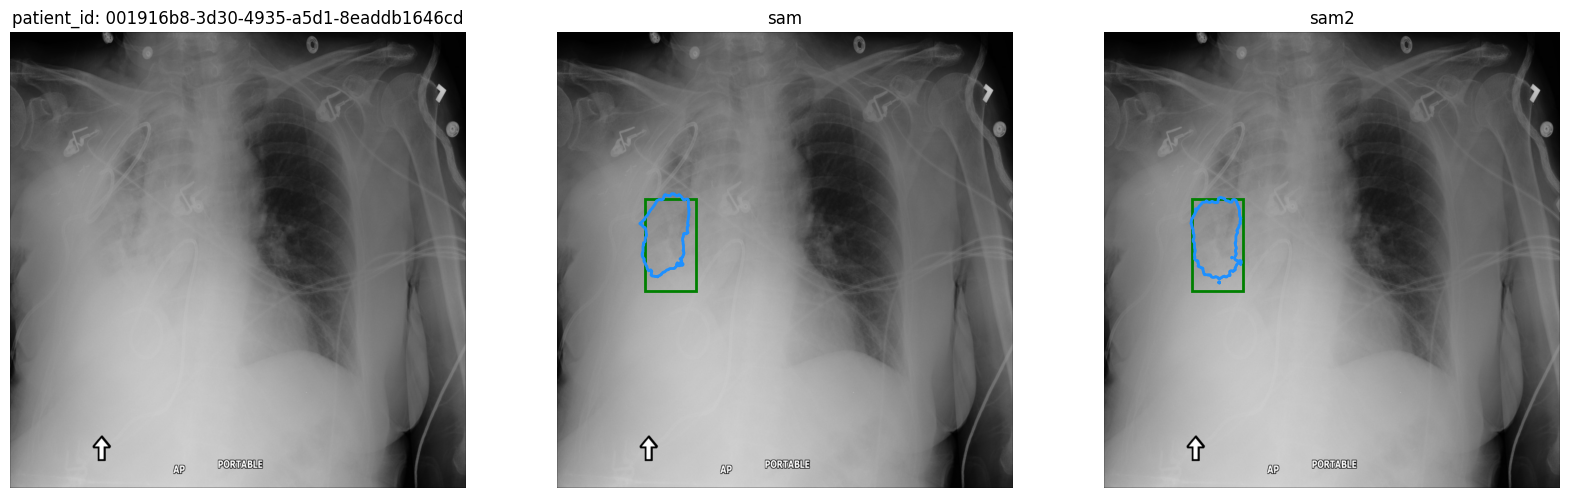

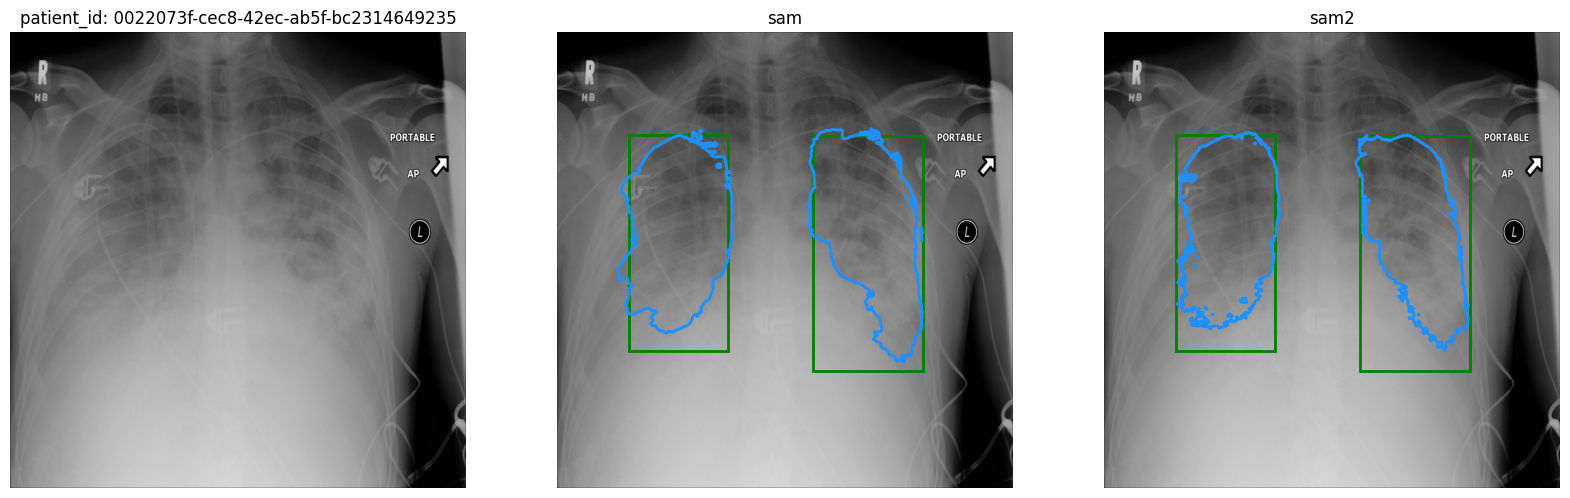

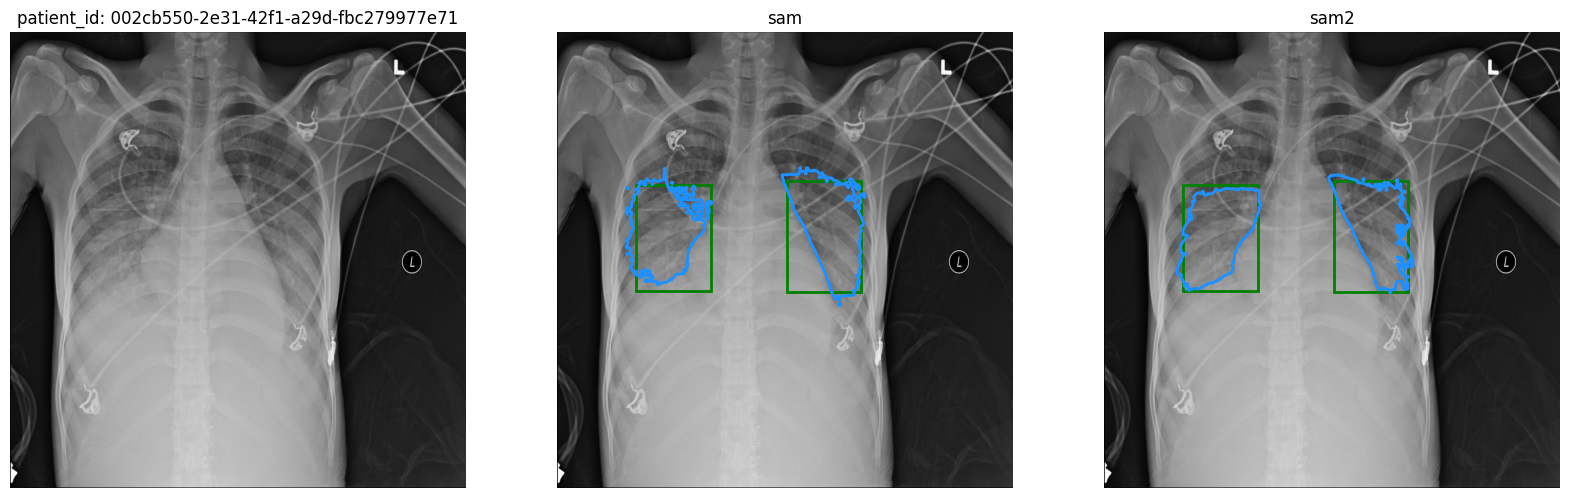

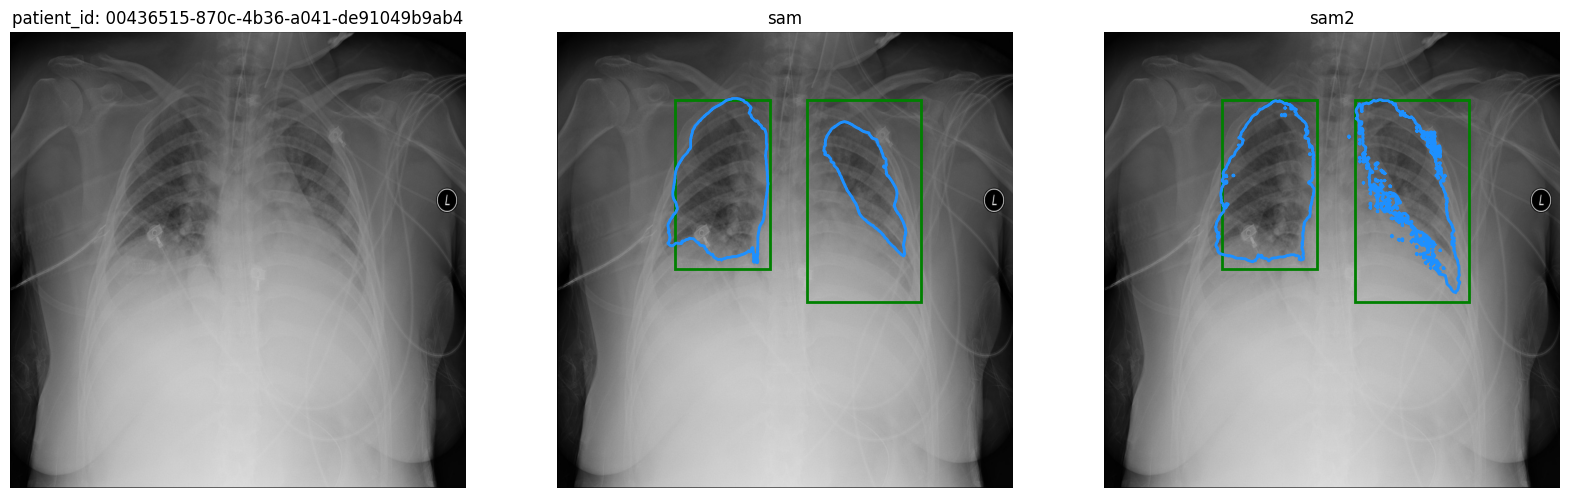

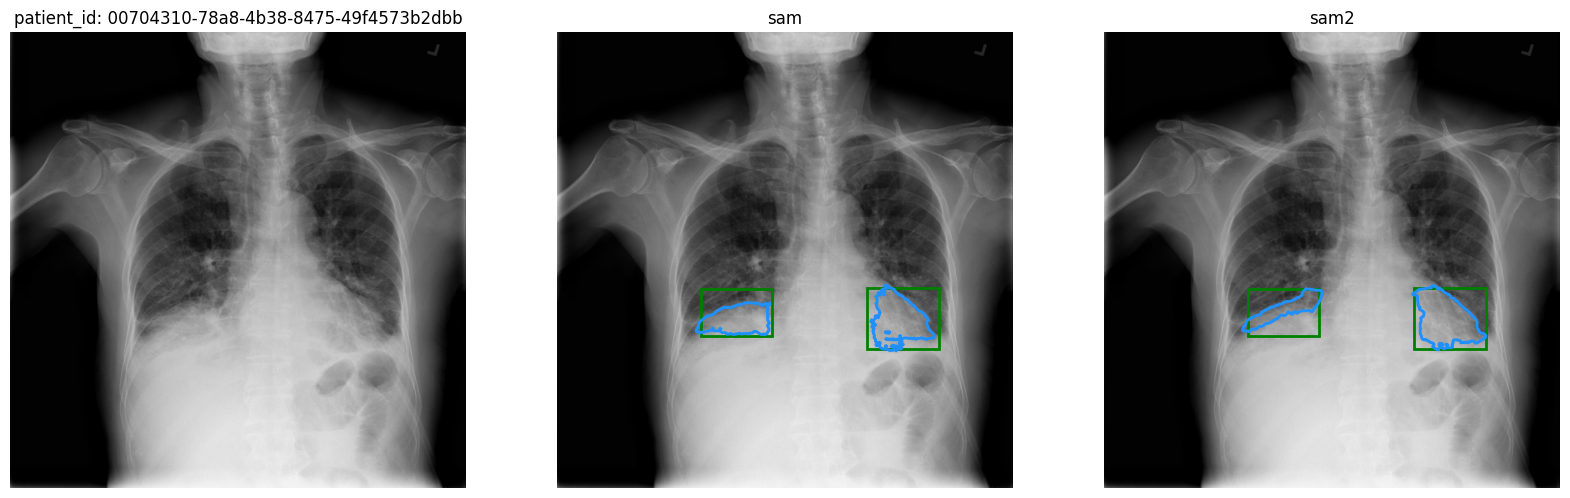

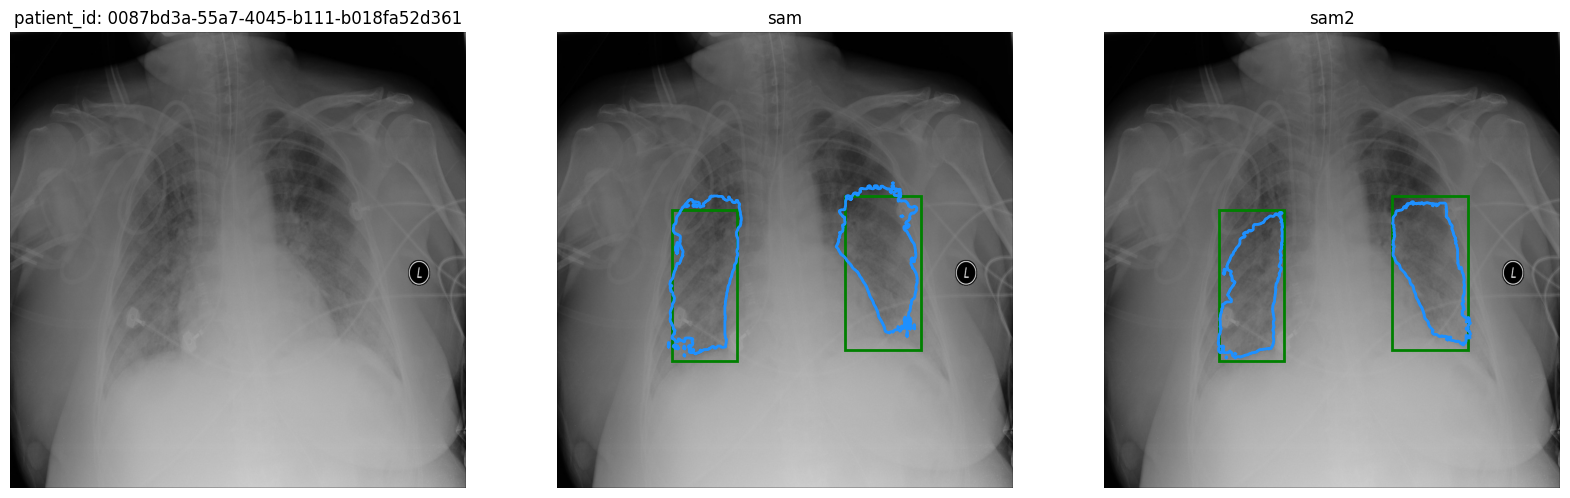

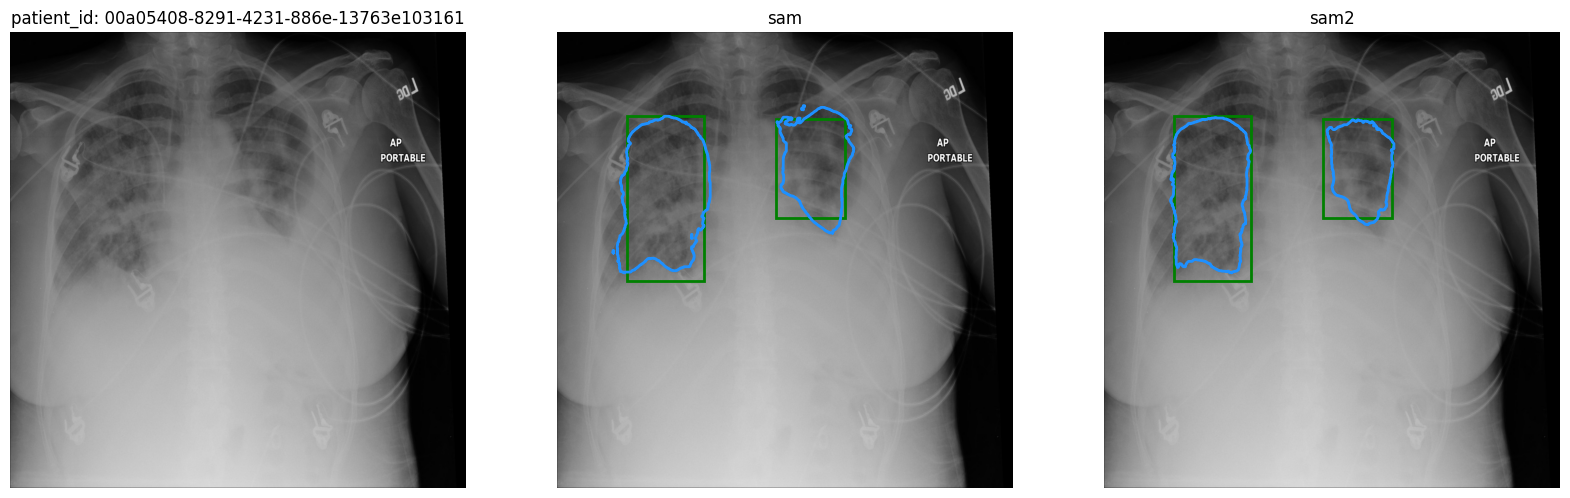

In [9]:
# Iterate through the first 2 keys of the bounding_boxes_dict
for patient_id, boxes in list(bounding_boxes_dict.items())[:10]:
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    axes[2].set_axis_off()
    # Read the DICOM file for the current patient_id
    dcm_file_path = f'cleaned_train_data/cleaned_stage_2_train_images/{patient_id}.dcm'
    dicom = pydicom.dcmread(dcm_file_path)
    
    # Convert to 3-channel RGB image if needed by SAM
    image = dicom.pixel_array
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # axes[0].imshow(image_rgb)
    # axes[0].set_title(f"patient_id: {patient_id}")
    
    # Encode the image into SAM
    predictor.set_image(image_rgb)
    predictor2.set_image(image_rgb)

    # Initialize an empty list to hold all the masks
    all_masks1 = []
    all_masks2 = []

    # Loop over each bounding box and predict masks one at a time
    for box in boxes:
        input_box = np.array(box)
        masks1, scores1, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # Use individual bounding box
            multimask_output=False
        )
        all_masks1.append(masks1)  # Store masks for each box
        masks2, scores2, _ = predictor2.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # Use individual bounding box
            multimask_output=False
        )
        all_masks2.append(masks2)  # Store masks for each box

    # Display the results
    axes[0].imshow(image_rgb)
    axes[1].imshow(image_rgb)
    axes[0].set_title(f"patient_id: {patient_id}")
    axes[1].set_title("sam")
    axes[2].set_title("sam2")
    for mask, box in zip(all_masks1, boxes):
        show_mask2(mask[0], axes[1])  # Show mask for each box
        show_box(box, axes[1])
    
    axes[2].imshow(image_rgb)
    for mask, box in zip(all_masks2, boxes):
        show_mask2(mask[0], axes[2])  # Show mask for each box
        show_box(box, axes[2])
    plt.savefig(f'testing_sam2/{patient_id}_sam2_masked.png', format='png', dpi=300)
    plt.show()